In [2]:
import os
import sys
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from IPython.display import clear_output

if os.path.abspath(os.path.join(os.getcwd(), "../../")) not in sys.path:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
    
from plan_generator.src.config import Configuration
from plan_generator.src.enums import LabelsOld, LabelsNew, Colors
from plan_generator.src.models import WallGenerator, RoomAllocator
from plan_generator.src.data import PlanDataCreator

In [ ]:
plan_data_creator = PlanDataCreator(mirroring=True, rotating=True)
plan_data_creator.create()

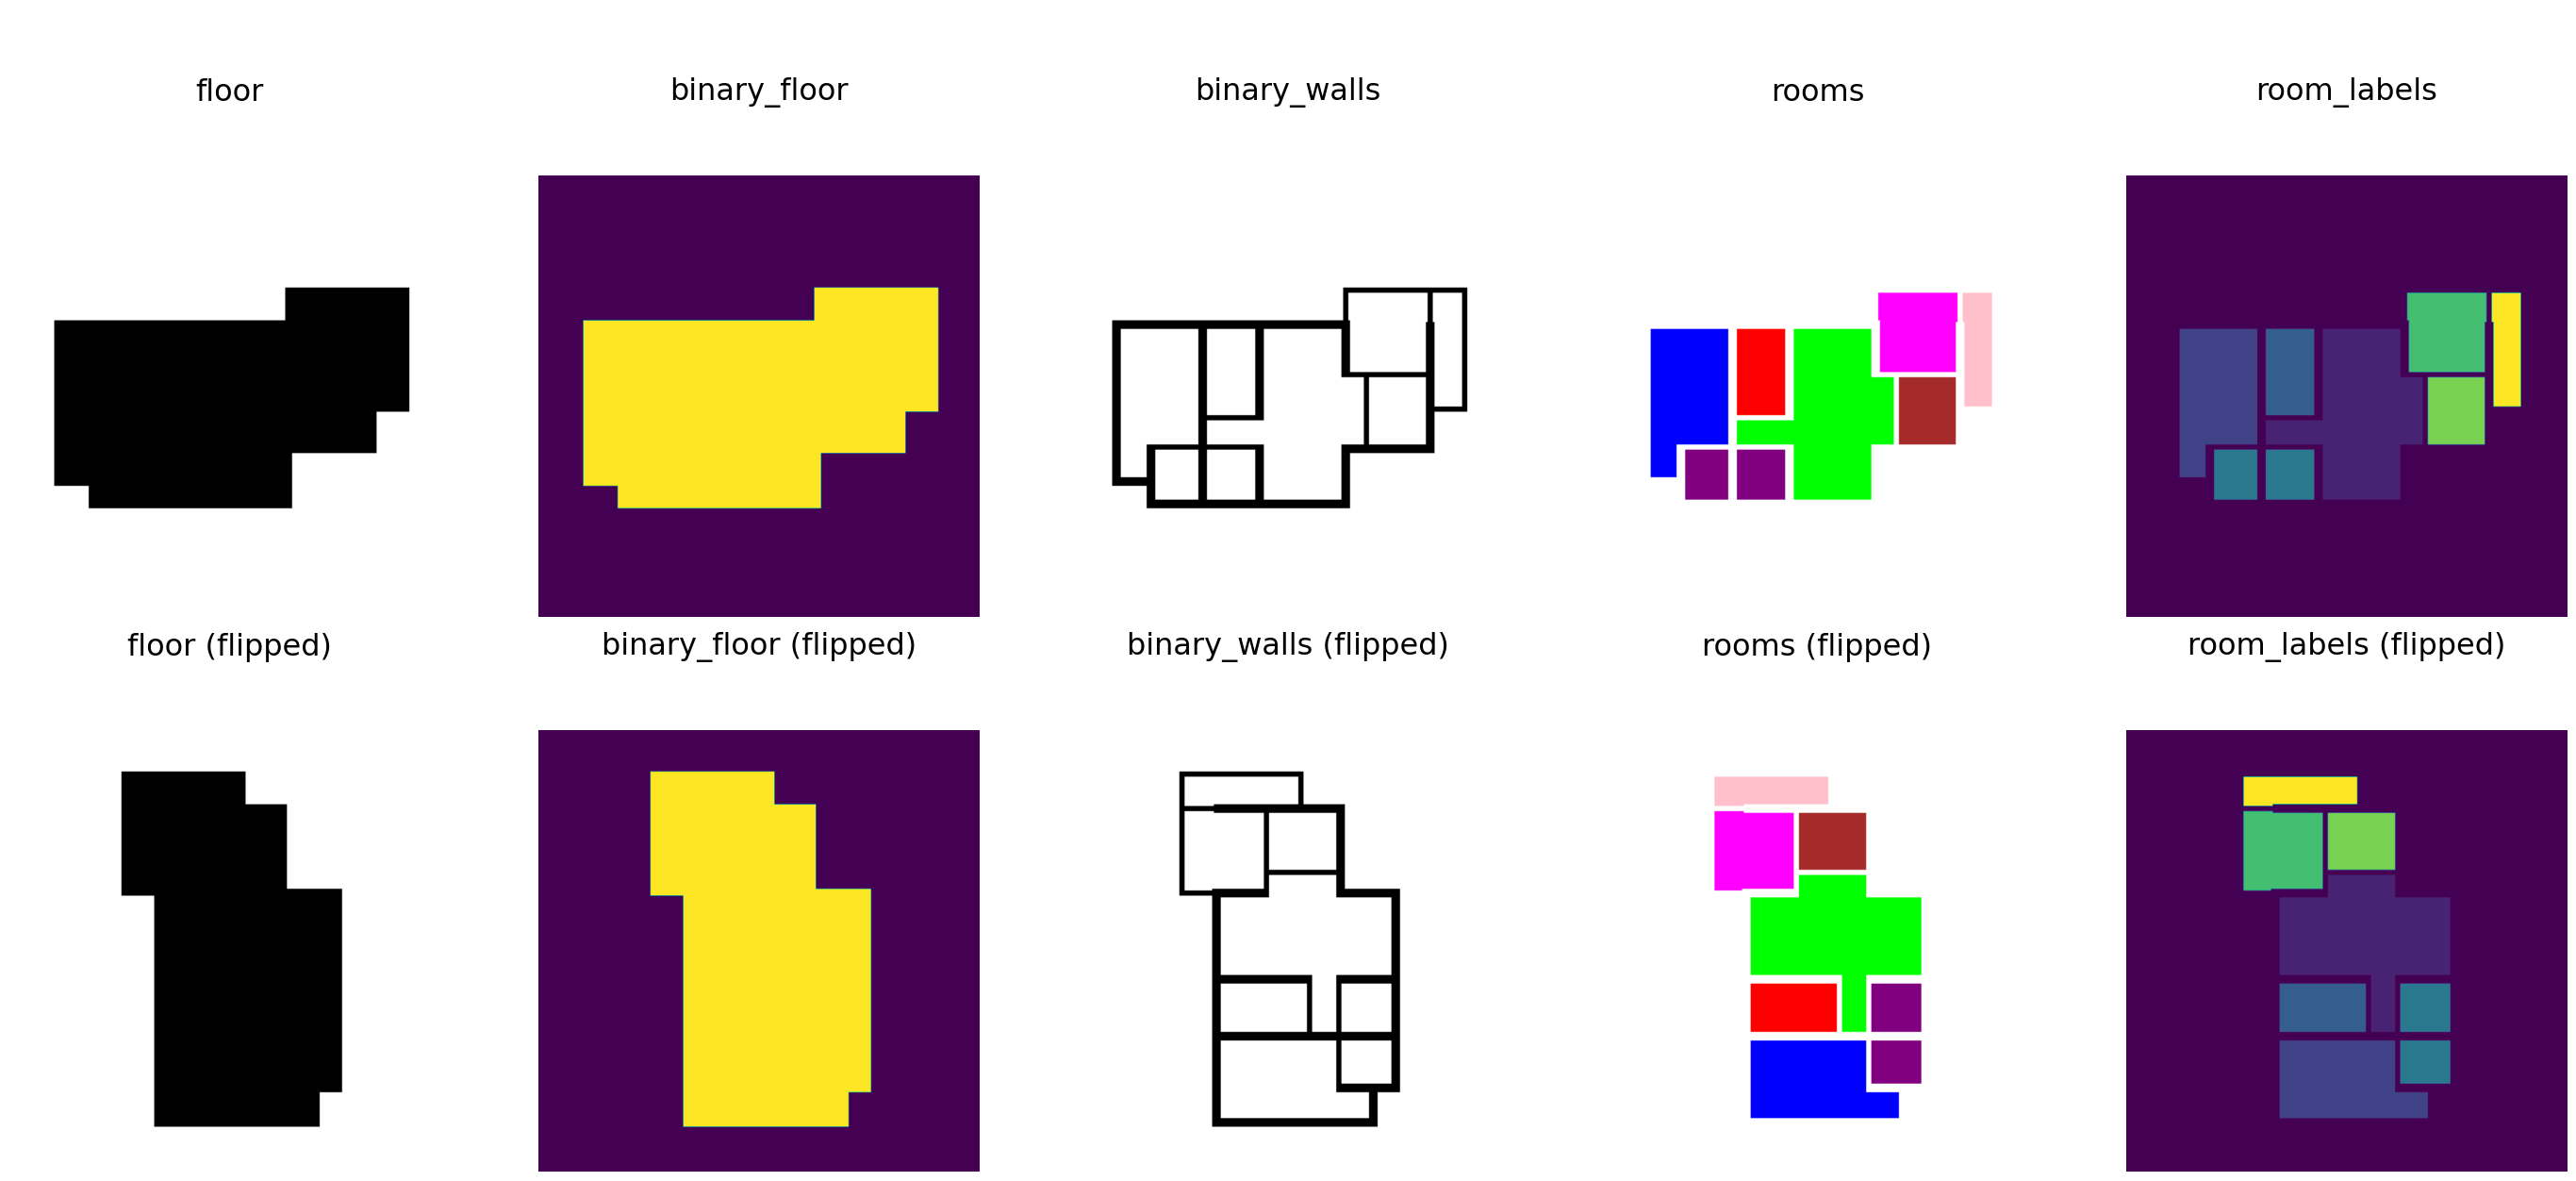

In [11]:
image_names = os.listdir(Configuration.DATA_PATH)

dataset = []

for i, image_name in enumerate(image_names[33333:]):
    if i % 5 == 0:
        clear_output(wait=True)
    
    image_path = os.path.join(Configuration.DATA_PATH, image_name)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(2, 5, figsize=(7 * 5, 14))
        
    exterior_walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    exterior_walls_mask = (
        (original_image[:, :, 0] == LabelsOld.EXTERIOR_WALL_1.value)
        | (original_image[:, :, 0] == LabelsOld.MAIN_ENTRANCE.value)
        | (original_image[:, :, 1] == LabelsOld.EXTERIOR_WALL_2.value)
    )
    
    exterior_walls[exterior_walls_mask] = Colors.BLACK.value
    
    interior_walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    interior_walls_mask = (
        (original_image[:, :, 1] == LabelsOld.INTERIOR_WALL.value)
        | (original_image[:, :, 1] == LabelsOld.INTERIOR_DOOR.value)
        | (original_image[:, :, 1] == LabelsOld.WALL_IN.value)
    )
    interior_walls[interior_walls_mask] = Colors.BLACK.value
    
    floor = np.zeros_like(original_image) + Colors.WHITE.value[0]
    floor[exterior_walls_mask] = Colors.BLACK.value
    _, floor, _, _ = cv2.floodFill(floor, mask=None, seedPoint=(0, 0), newVal=(0, 0, 0))
    floor = abs(Colors.WHITE.value[0] - floor)
    floor[exterior_walls_mask] = Colors.BLACK.value
    
    binary_floor = np.zeros((floor.shape[0], floor.shape[1], 1))
    binary_floor[floor[:, :, 0] == 0] = 1
    
    walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    walls[exterior_walls_mask] = Colors.BLACK.value
    walls[interior_walls_mask] = Colors.BLACK.value
    
    binary_walls = np.zeros((walls.shape[0], walls.shape[1], 1))
    binary_walls[walls[:, :, 0] == 0] = 1
    
    channel_1_rooms = np.zeros(shape=(original_image.shape[0], original_image.shape[1], 1))
    channel_3_rooms = np.zeros_like(original_image) + Colors.WHITE.value[0]
    
    room_types = np.unique(original_image[:, :, 1])
    for room_type in room_types:
        room_color = Colors.COLOR_MAP_OLD.value.get(room_type)
        if room_color is not None:
            room_mask = original_image[:, :, 1] == room_type
            channel_3_rooms[room_mask] = room_color
            channel_1_rooms[room_mask] = LabelsNew.CLASS_MAP.value[room_type]
            
    permuted_binary_floor = torch.FloatTensor(binary_floor).permute(2, 0, 1)
    permuted_binary_walls = torch.FloatTensor(binary_walls).permute(2, 0, 1)
    permuted_channel_3_rooms = torch.LongTensor(channel_3_rooms).permute(2, 0, 1)
    permuted_channel_1_rooms = torch.LongTensor(channel_1_rooms).permute(2, 0, 1)
    
    dataset.append(
        [
            permuted_binary_floor,
            permuted_binary_walls, 
            permuted_channel_1_rooms,
            permuted_channel_3_rooms, 
        ]
    )
    
    components = [
        floor, 
        binary_floor, 
        walls, 
        channel_3_rooms, 
        channel_1_rooms,
        np.rot90(floor, 1),
        np.rot90(binary_floor, 1),
        np.rot90(walls, 1),
        np.transpose(torch.rot90(permuted_channel_3_rooms, 1, (1, 2)).numpy(), (1, 2, 0)),
        np.transpose(torch.rot90(permuted_channel_1_rooms, 1, (1, 2)).numpy(), (1, 2, 0)),
        
    ]
    titles = [
        "floor", 
        "binary_floor", 
        "binary_walls", 
        "rooms", 
        "room_labels",
        "floor (flipped)",
        "binary_floor (flipped)",
        "binary_walls (flipped)",
        "rooms (flipped)",
        "room_labels (flipped)",
    ]
    
    for ax, component, title in zip(axes.flatten(), components, titles):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("\n\n" + title + "\n\n", fontsize=23)
        ax.axis("off")
        ax.imshow(component)
        
    break

In [3]:
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 1

class PlanDataset(Dataset):
    def __init__(self, plan_dataset):
        self.plan_dataset = plan_dataset
    
    def __len__(self):
        return len(self.plan_dataset)
    
    def __getitem__(self, index):
        # floor, exterior_walls, walls, rooms, labels
        floor, walls, rooms, _ = self.plan_dataset[index]
        return floor.to("cuda"), walls.to("cuda"), rooms.to("cuda")
    
plan_dataset = PlanDataset(dataset)
plan_dataloader = DataLoader(
    dataset=plan_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

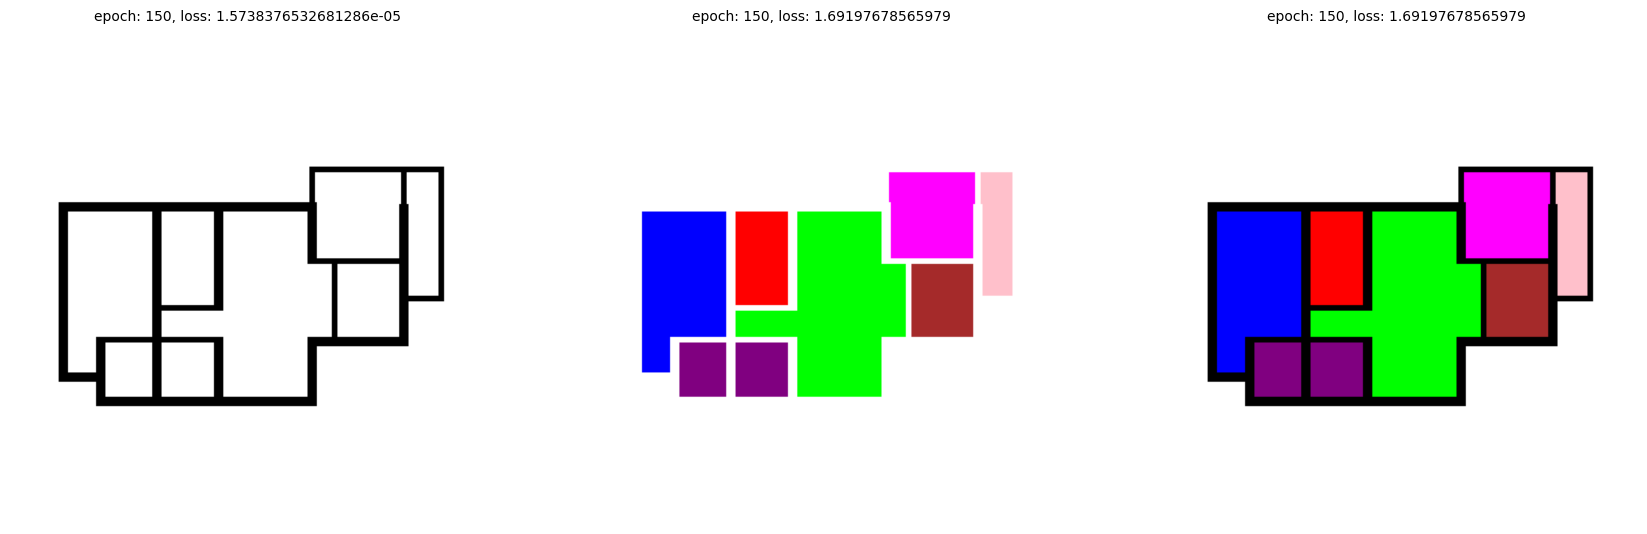

In [5]:
import cv2

steps = [64, 128, 256, 512, 1024]

wall_generator = WallGenerator(in_channels=1, out_channels=1, steps=steps, size=256, repeat=5)
wall_generator_loss_function = nn.BCELoss()
wall_generator_optimizer = torch.optim.Adam(wall_generator.parameters(), lr=0.0002)

room_allocator = RoomAllocator(
    in_channels=1, 
    out_channels=LabelsNew.NUM_CLASSES.value, 
    steps=steps, 
    size=256, 
    repeat=5
)

room_allocator_loss_function = nn.CrossEntropyLoss()
room_allocator_optimizer = torch.optim.Adam(room_allocator.parameters(), lr=0.0002)

kernel = np.ones((7, 7), np.uint8) 

for epoch in range(1, 150 + 1):
    for floor, walls, rooms in plan_dataloader:
        
        wall_generator_optimizer.zero_grad()
        
        generated_walls = wall_generator(floor)
        masked_generated_walls = generated_walls.clone()
        masked_generated_walls[floor == 0] = 0
        
        wall_generator_loss = wall_generator_loss_function(masked_generated_walls, walls)
        
        wall_generator_loss.backward()
        wall_generator_optimizer.step()
        
        room_allocator_optimizer.zero_grad()
        
        generated_rooms = room_allocator(walls)
        masked_generated_rooms = generated_rooms.clone()
        masked_generated_rooms[floor.expand_as(generated_rooms) == 0] = 0
        
        room_allocator_loss = room_allocator_loss_function(masked_generated_rooms, rooms.squeeze(1))
        room_allocator_loss.backward()
        room_allocator_optimizer.step()
        
        walls_to_visualize = masked_generated_walls.permute(0, 2, 3, 1)
        walls_to_visualize = (walls_to_visualize.detach().cpu().numpy() > 0.5).astype(int)
        walls_to_visualize = np.where(walls_to_visualize == 0, 255, 0)[0]
        walls_to_visualize = walls_to_visualize.astype(np.uint8).squeeze(-1)
        walls_to_visualize = cv2.erode(walls_to_visualize.astype(np.uint8), kernel, iterations=1)
        walls_to_visualize = cv2.dilate(walls_to_visualize.astype(np.uint8), kernel, iterations=1)
        
        rooms_to_visualize = torch.argmax(masked_generated_rooms, dim=1)
        rooms_to_visualize = rooms_to_visualize.detach().cpu().numpy()
        rooms_to_visualize = np.transpose(rooms_to_visualize, (1, 2, 0))
        rooms_to_visualize = rooms_to_visualize.astype(np.uint8).squeeze(-1)
        rooms_to_visualize = cv2.erode(rooms_to_visualize.astype(np.uint8), kernel, iterations=1)
        rooms_to_visualize = cv2.dilate(rooms_to_visualize.astype(np.uint8), kernel, iterations=1)
        
        # Create an empty RGB image
        rooms_channel_3 = np.zeros((rooms_to_visualize.shape[0], rooms_to_visualize.shape[1], 3), dtype=np.uint8)
        rooms_channel_3 += Colors.WHITE.value[0]

        # Map each label to its corresponding color
        for label, color in Colors.COLOR_MAP_NEW.value.items():
            mask = rooms_to_visualize == label
            rooms_channel_3[:, :, 0][mask] = color[0]
            rooms_channel_3[:, :, 1][mask] = color[1]
            rooms_channel_3[:, :, 2][mask] = color[2]
            
        walls_and_rooms = rooms_channel_3.copy()
        walls_and_rooms[:, :, 0][walls_to_visualize == 0] = Colors.BLACK.value[0]
        walls_and_rooms[:, :, 1][walls_to_visualize == 0] = Colors.BLACK.value[1]
        walls_and_rooms[:, :, 2][walls_to_visualize == 0] = Colors.BLACK.value[2]
        
        fig, axes = plt.subplots(1, 3, figsize=(21, 7))
        ax_1, ax_2, ax_3 = axes.flatten()
        ax_1.imshow(walls_to_visualize, cmap="gray")  # Assuming single-channel output
        ax_1.axis('off')
        ax_1.set_title(f"epoch: {epoch}, loss: {wall_generator_loss.item()} \n", fontsize=10)
        
        ax_2.imshow(rooms_channel_3)
        ax_2.axis('off')
        ax_2.set_title(f"epoch: {epoch}, loss: {room_allocator_loss.item()} \n", fontsize=10)
        
        ax_3.imshow(walls_and_rooms)
        ax_3.axis('off')
        ax_3.set_title(f"epoch: {epoch}, loss: {room_allocator_loss.item()} \n", fontsize=10)
        
        plt.show()
        clear_output(wait=True) 
        
    #     break
    # break

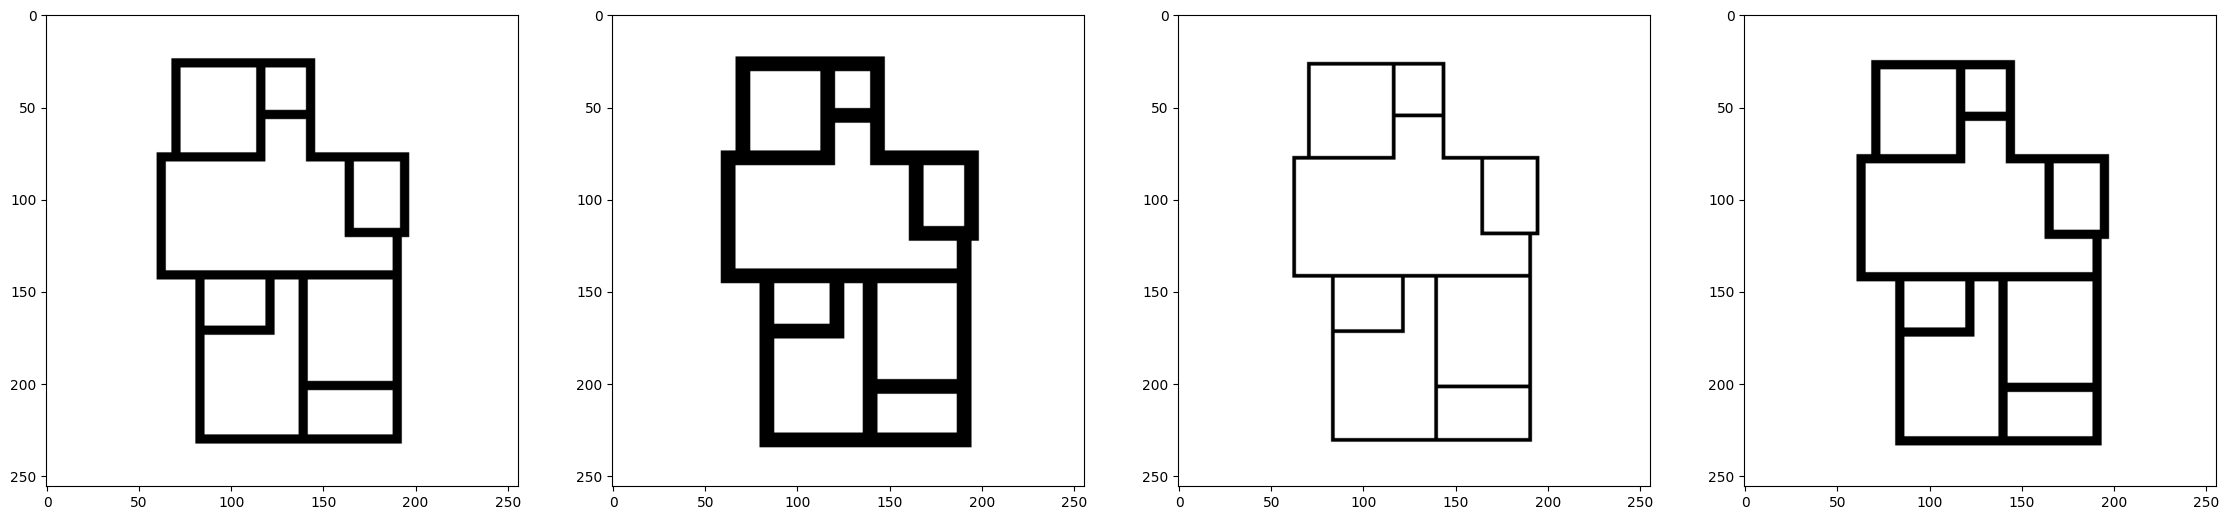

In [36]:
import cv2

fig, axes = plt.subplots(1, 4, figsize=(28,7))
ax_1, ax_2, ax_3, ax_4 = axes.flatten()

ax_1.imshow(walls_to_visualize, cmap="gray")

# Convert walls_to_visualize to uint8
walls_to_visualize_uint8 = walls_to_visualize.astype(np.uint8)

kernel = np.ones((4, 4), np.uint8) 

img_erosion = cv2.erode(walls_to_visualize_uint8, kernel, iterations=1) 
ax_2.imshow(img_erosion, cmap="gray")

img_dilation = cv2.dilate(walls_to_visualize_uint8, kernel, iterations=1) 
ax_3.imshow(img_dilation, cmap="gray")

img_erosion_and_dilation = cv2.erode(walls_to_visualize_uint8, kernel, iterations=1)
img_erosion_and_dilation = cv2.dilate(img_erosion_and_dilation, kernel, iterations=1)
ax_4.imshow(img_erosion_and_dilation, cmap="gray")

plt.show()

In [34]:
walls_to_visualize_uint8.sum(), img_erosion_and_dilation.sum()

(15254355, 15254355)